In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.misc import derivative
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time

In [2]:
def logtargetpdf(x, target, kernel):
    lnp = 0.0
    if (target == 'Exp'):
            lnp = -x if (x>=0) else -500
    elif (target == 'Folded_Gaussian'):
            lnp = -x*x/2 if (x>=0) else -500
    elif (target == 'N01_T2'):
            lnp = -x*x/2
    elif (target == 'N01_Logistic'):
            lnp = -x*x/2
    return (lnp)

def transform_x(x,transform):
    y = 0.0
    if (transform == 'Exp(1)_CDF'):
        y = np.exp(-x)
    elif (transform == 't(2)_CDF'):
        y = 1 - 1/2 * (1+np.sqrt(1-2/(np.square(x)+2))) if x<0 else 1/2 * (1+np.sqrt(1-2/(np.square(x)+2)))
    elif (transform == 'logistic_CDF'):
        y = 1/(1+np.exp(-x))
    return y

def transform_inverse(x,transform):
    y = 0.0
    if (transform == 'Exp(1)_CDF'):
        y = -np.log(x)
    elif (transform == 't(2)_CDF'):
        y = np.sqrt(2/(1-np.square(2*x-1))-2) * (-1 if x<0.5 else 1)
    elif (transform == 'logistic_CDF'):
        y = -np.log(1/x-1)
    return y

def log_proposal_ratio(x,transform,kernel):
    ratio = 0.0
    if 'Trans' in kernel:
        if (transform == 'Exp(1)_CDF'):
            ratio = -x
        elif (transform == 't(2)_CDF'):
            ratio = -3/2*np.log(1+x**2/2)
        elif (transform == 'logistic_CDF'):
            ratio = -x - 2*np.log(1+np.exp(-x))
    return ratio

In [3]:
#MCMC sampling implementation
# np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
size = len(range(-burnin,nround))
sigmaset = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6, 7, 8]
kernelset = ['Uniform','TransUniform','TransBactrian','TransStrawHat']
targetset = {'Exp':'Exp(1)_CDF', 'Folded_Gaussian':'Exp(1)_CDF', 'N01_T2':'t(2)_CDF', 'N01_Logistic':'logistic_CDF'}

sample_Normal = np.random.normal(size = size)
sample_Uniform = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size)
sample_bactrian = random_bactrian(size = size)
sample_strawhat = random_strawhat(size=size)
target_result = {}

for target,transform in targetset.items():
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}
    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = 0; 
            x = abs(np.random.random() - 0.5)
            y = np.zeros(nround)
            for j in range(-burnin,nround):
                x_trans = transform_x(x,transform) if 'Trans' in kernel else x
                if (j==0):
                    accept = 0;
                if 'Gaussian' in kernel:
                    xnew_trans = x_trans + sample_Normal[j+burnin] * sigma
                elif 'Uniform' in kernel:
                    xnew_trans = x_trans + sample_Uniform[j+burnin] *sigma
                elif 'Bactrian' in kernel:
                    xnew_trans = x_trans + sample_bactrian[j+burnin] *sigma
                elif 'StrawHat' in kernel:
                    xnew_trans = x_trans + sample_strawhat[j+burnin] *sigma

                if (('Trans' in kernel) & (not (0 <= xnew_trans <= 1))):
                    xnew_trans = reflect(xnew_trans, xL=0, xU=1)
                if (((target=='Exp') | (target=='Folded_Gaussian')) & ('Trans' not in kernel)) & (xnew_trans<0):
                    xnew_trans = -xnew_trans
                
                xnew = transform_inverse(xnew_trans,transform) if ('Trans' in kernel) else xnew_trans
                
                pi_dif = logtargetpdf(xnew,target,kernel) - logtargetpdf(x,target,kernel) + log_proposal_ratio(x,transform,kernel)-log_proposal_ratio(xnew,transform,kernel)
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    x = xnew
                    accept += 1
                if (j>=0):
                    y[j] = x
            eff = (Eff_IntegratedCorrelationTime(y))
            rho = [rho_k(y,i) for i in range(1,11)]
            exx2 = sum(np.square(y[1:] - y[:-1]))
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            Rho.append(rho)
            Sample.append(y.copy())
            print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel]
print('总共用时: %f'% (time.time()-begin_total))

Target:Exp|Kernel:Uniform|sigma:0.1|eff:0.0013|Pjump:0.9579|Exx2:0.009|rho1:0.9952|rho2:0.9905|Time:15.84
Target:Exp|Kernel:Uniform|sigma:0.3|eff:0.0092|Pjump:0.8802|Exx2:0.0653|rho1:0.968|rho2:0.94|Time:8.71
Target:Exp|Kernel:Uniform|sigma:0.5|eff:0.0243|Pjump:0.8114|Exx2:0.1473|rho1:0.925|rho2:0.8634|Time:8.66
Target:Exp|Kernel:Uniform|sigma:0.7|eff:0.0416|Pjump:0.7502|Exx2:0.2362|rho1:0.882|rho2:0.7905|Time:8.43
Target:Exp|Kernel:Uniform|sigma:0.8|eff:0.0501|Pjump:0.7222|Exx2:0.2793|rho1:0.8609|rho2:0.7549|Time:8.21
Target:Exp|Kernel:Uniform|sigma:0.9|eff:0.0605|Pjump:0.6943|Exx2:0.3189|rho1:0.8397|rho2:0.72|Time:8.19
Target:Exp|Kernel:Uniform|sigma:1|eff:0.073|Pjump:0.6692|Exx2:0.3577|rho1:0.819|rho2:0.6861|Time:8.25
Target:Exp|Kernel:Uniform|sigma:1.1|eff:0.0778|Pjump:0.645|Exx2:0.3932|rho1:0.8065|rho2:0.6664|Time:8.15
Target:Exp|Kernel:Uniform|sigma:1.3|eff:0.102|Pjump:0.5996|Exx2:0.452|rho1:0.7716|rho2:0.6104|Time:8.19
Target:Exp|Kernel:Uniform|sigma:1.5|eff:0.1179|Pjump:0.56|Ex

Target:Exp|Kernel:TransBactrian|sigma:2.4|eff:0.9405|Pjump:1.0|Exx2:1.9456|rho1:0.028|rho2:-0.001|Time:13.06
Target:Exp|Kernel:TransBactrian|sigma:2.5|eff:0.9659|Pjump:1.0|Exx2:1.9689|rho1:0.0139|rho2:0.0|Time:13.45
Target:Exp|Kernel:TransBactrian|sigma:2.6|eff:0.9912|Pjump:1.0|Exx2:1.994|rho1:0.0042|rho2:-0.0002|Time:13.06
Target:Exp|Kernel:TransBactrian|sigma:2.8|eff:1.0102|Pjump:1.0|Exx2:2.024|rho1:-0.008|rho2:-0.0017|Time:13.05
Target:Exp|Kernel:TransBactrian|sigma:3.0|eff:1.0095|Pjump:1.0|Exx2:2.0102|rho1:-0.0088|rho2:0.0005|Time:13.33
Target:Exp|Kernel:TransBactrian|sigma:3.2|eff:0.9903|Pjump:1.0|Exx2:2.0113|rho1:-0.0047|rho2:0.0003|Time:13.46
Target:Exp|Kernel:TransBactrian|sigma:3.5|eff:1.0073|Pjump:1.0|Exx2:2.0038|rho1:-0.0011|rho2:0.0004|Time:13.41
Target:Exp|Kernel:TransBactrian|sigma:4|eff:0.9883|Pjump:1.0|Exx2:2.0041|rho1:0.0009|rho2:0.001|Time:13.49
Target:Exp|Kernel:TransBactrian|sigma:4.5|eff:0.9998|Pjump:1.0|Exx2:1.9934|rho1:0.0002|rho2:0.0019|Time:13.35
Target:Exp|Ker

Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.1|eff:0.0356|Pjump:0.9259|Exx2:0.0694|rho1:0.9039|rho2:0.8248|Time:12.22
Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.3|eff:0.2778|Pjump:0.8418|Exx2:0.3265|rho1:0.5501|rho2:0.3167|Time:11.94
Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.5|eff:0.632|Pjump:0.8315|Exx2:0.5711|rho1:0.2158|rho2:0.0528|Time:12.82
Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.7|eff:0.9916|Pjump:0.8421|Exx2:0.7246|rho1:0.0026|rho2:0.0007|Time:12.99
Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.8|eff:1.0776|Pjump:0.8387|Exx2:0.7572|rho1:-0.0364|rho2:0.0038|Time:13.71
Target:Folded_Gaussian|Kernel:TransUniform|sigma:0.9|eff:1.0665|Pjump:0.8322|Exx2:0.7512|rho1:-0.0333|rho2:0.0031|Time:13.04
Target:Folded_Gaussian|Kernel:TransUniform|sigma:1|eff:0.9819|Pjump:0.8283|Exx2:0.7249|rho1:0.0055|rho2:0.0028|Time:13.23
Target:Folded_Gaussian|Kernel:TransUniform|sigma:1.1|eff:0.8631|Pjump:0.8315|Exx2:0.6739|rho1:0.072|rho2:0.0075|Time:13.76
Target:Fol

Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.1|eff:1.9987|Pjump:0.8327|Exx2:0.9738|rho1:-0.3421|rho2:0.1242|Time:15.22
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.3|eff:1.2942|Pjump:0.8178|Exx2:0.8298|rho1:-0.139|rho2:0.0223|Time:15.54
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.5|eff:0.7316|Pjump:0.8394|Exx2:0.6177|rho1:0.1524|rho2:0.0262|Time:14.81
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.7|eff:0.48|Pjump:0.8494|Exx2:0.4798|rho1:0.3387|rho2:0.1205|Time:15.91
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.8|eff:0.4598|Pjump:0.8453|Exx2:0.4634|rho1:0.363|rho2:0.1376|Time:14.3
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:1.9|eff:0.477|Pjump:0.84|Exx2:0.4759|rho1:0.3447|rho2:0.1247|Time:14.22
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:2|eff:0.5301|Pjump:0.8355|Exx2:0.5084|rho1:0.301|rho2:0.0967|Time:15.11
Target:Folded_Gaussian|Kernel:TransStrawHat|sigma:2.1|eff:0.6098|Pjump:0.8354|Exx2:0.5589|rho1:0.2343|rho2:0.0597|Time:14.59
Target:Fo

Target:N01_T2|Kernel:TransUniform|sigma:2.6|eff:0.6621|Pjump:0.8299|Exx2:1.5976|rho1:0.1993|rho2:0.0422|Time:25.01
Target:N01_T2|Kernel:TransUniform|sigma:2.8|eff:0.6998|Pjump:0.8282|Exx2:1.6589|rho1:0.1715|rho2:0.0324|Time:24.39
Target:N01_T2|Kernel:TransUniform|sigma:3.0|eff:0.7609|Pjump:0.8311|Exx2:1.7269|rho1:0.1366|rho2:0.02|Time:23.94
Target:N01_T2|Kernel:TransUniform|sigma:3.2|eff:0.7874|Pjump:0.8297|Exx2:1.7722|rho1:0.1143|rho2:0.0134|Time:25.04
Target:N01_T2|Kernel:TransUniform|sigma:3.5|eff:0.7175|Pjump:0.8313|Exx2:1.6807|rho1:0.1614|rho2:0.0286|Time:26.3
Target:N01_T2|Kernel:TransUniform|sigma:4|eff:0.7183|Pjump:0.8281|Exx2:1.6752|rho1:0.1619|rho2:0.0287|Time:26.41
Target:N01_T2|Kernel:TransUniform|sigma:4.5|eff:0.7617|Pjump:0.8292|Exx2:1.7326|rho1:0.1344|rho2:0.0202|Time:26.38
Target:N01_T2|Kernel:TransUniform|sigma:5|eff:0.6944|Pjump:0.8293|Exx2:1.6557|rho1:0.1719|rho2:0.0297|Time:26.18
Target:N01_T2|Kernel:TransUniform|sigma:6|eff:0.6968|Pjump:0.8302|Exx2:1.6578|rho1:0.17

Target:N01_Logistic|Kernel:Uniform|sigma:0.3|eff:0.0188|Pjump:0.897|Exx2:0.0761|rho1:0.9618|rho2:0.9251|Time:9.18
Target:N01_Logistic|Kernel:Uniform|sigma:0.5|eff:0.0485|Pjump:0.8302|Exx2:0.1866|rho1:0.906|rho2:0.8214|Time:8.03
Target:N01_Logistic|Kernel:Uniform|sigma:0.7|eff:0.083|Pjump:0.7657|Exx2:0.3195|rho1:0.8396|rho2:0.7072|Time:8.17
Target:N01_Logistic|Kernel:Uniform|sigma:0.8|eff:0.1012|Pjump:0.7348|Exx2:0.3886|rho1:0.8054|rho2:0.6525|Time:8.27
Target:N01_Logistic|Kernel:Uniform|sigma:0.9|eff:0.1199|Pjump:0.7043|Exx2:0.4567|rho1:0.7703|rho2:0.5988|Time:7.95
Target:N01_Logistic|Kernel:Uniform|sigma:1|eff:0.1404|Pjump:0.6744|Exx2:0.5216|rho1:0.7377|rho2:0.5512|Time:8.43
Target:N01_Logistic|Kernel:Uniform|sigma:1.1|eff:0.1578|Pjump:0.6464|Exx2:0.5845|rho1:0.707|rho2:0.508|Time:8.43
Target:N01_Logistic|Kernel:Uniform|sigma:1.3|eff:0.1944|Pjump:0.5933|Exx2:0.691|rho1:0.6549|rho2:0.4381|Time:8.35
Target:N01_Logistic|Kernel:Uniform|sigma:1.5|eff:0.2255|Pjump:0.5437|Exx2:0.774|rho1:0.6

Target:N01_Logistic|Kernel:TransBactrian|sigma:1.8|eff:0.545|Pjump:0.6999|Exx2:1.434|rho1:0.2826|rho2:0.0849|Time:21.33
Target:N01_Logistic|Kernel:TransBactrian|sigma:1.9|eff:0.5402|Pjump:0.7001|Exx2:1.4229|rho1:0.2906|rho2:0.0897|Time:20.89
Target:N01_Logistic|Kernel:TransBactrian|sigma:2|eff:0.5474|Pjump:0.6999|Exx2:1.4235|rho1:0.2878|rho2:0.0879|Time:21.45
Target:N01_Logistic|Kernel:TransBactrian|sigma:2.1|eff:0.5562|Pjump:0.6998|Exx2:1.4517|rho1:0.2757|rho2:0.0831|Time:21.58
Target:N01_Logistic|Kernel:TransBactrian|sigma:2.2|eff:0.5703|Pjump:0.6997|Exx2:1.4788|rho1:0.2613|rho2:0.0737|Time:21.33
Target:N01_Logistic|Kernel:TransBactrian|sigma:2.3|eff:0.6035|Pjump:0.6992|Exx2:1.5088|rho1:0.2444|rho2:0.0654|Time:21.17
Target:N01_Logistic|Kernel:TransBactrian|sigma:2.4|eff:0.617|Pjump:0.6997|Exx2:1.5406|rho1:0.2311|rho2:0.0577|Time:20.85
Target:N01_Logistic|Kernel:TransBactrian|sigma:2.5|eff:0.6392|Pjump:0.6996|Exx2:1.5694|rho1:0.2164|rho2:0.0504|Time:21.4
Target:N01_Logistic|Kernel:Tra

In [6]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax(target_result[target][0][i]) for i in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target])-1)]
        rho1 = info[3][0]; rho2 = info[3][1]
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2    
                                       Exp
Uniform                   2.5      0.165    0.409    0.588    0.706    0.503   
TransUniform              0.8      1.301    1.0      2.281    -0.14    0.032   
TransBactrian             0.9      2.01     1.0      2.825    -0.409   0.257   
TransStrawHat             1.0      2.09     1.0      2.925    -0.471   0.36    
                                       Folded_Gaussian
Uniform                   1.5      0.283    0.544    0.328    0.55     0.308   
TransUniform              0.8      1.078    0.839    0.757    -0.036   0.004   
TransBactrian             0.9      1.935    0.836    0.96     -0.323   0.109   
TransStrawHat             1.0      2.228    0.843    1.011    -0.389   0.16    
                                       N01_T2
Uniform                   2.1      0.278    0.423    0.879    0.56     0.316   
TransUniform              0.9      0.969    0.829    1.9

### The plot below is the probability density of  target after transformed:

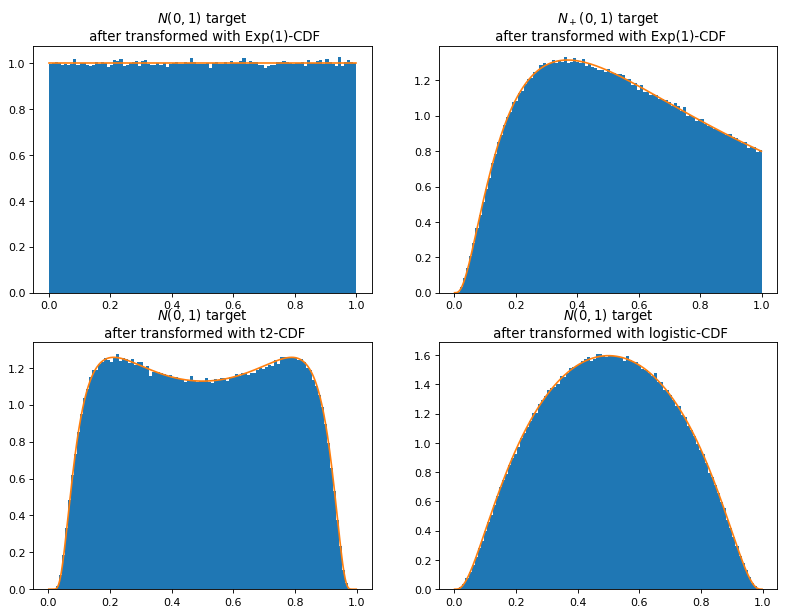

In [8]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

def logistic_inverse(x):
    return(-np.log(1/x-1))
#     return scipy.stats.logistic.ppf(x)

def logistic_diff(x):
    return(abs(1/x+1/(1-x)))
#     return abs(derivative(logistic_inverse,x,dx=1e-6))

def t_inverse(x):
    return scipy.stats.t.ppf(x,df=2)

def t_diff(x):
    return abs(derivative(t_inverse,x,dx=1e-6))

def exp_inverse(x):
    return(-np.log(x))

def exp_diff(x):
    return(abs(1/x))

from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')

ori = np.random.exponential(size=1000000,scale=1.0)
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
yindex = np.ones(len(xindex))
plt.subplot(221)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with Exp(1)-CDF')

ori = abs(np.random.normal(size=1000000))
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([exp_inverse(i) for i in xindex])
diff_term = np.array([exp_diff(i) for i in xindex])
yindex = 2*scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(222)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N_+(0,1)$ target \n after transformed with Exp(1)-CDF')


ori = np.random.normal(size=1000000)
trans = scipy.stats.t.cdf(x=ori,df=2)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([t_inverse(i) for i in xindex])
diff_term = np.array([t_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(223)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with t2-CDF')

ori = np.random.normal(size=1000000)
trans = scipy.stats.logistic.cdf(x=ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([logistic_inverse(i) for i in xindex])
diff_term = np.array([logistic_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(224)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with logistic-CDF')

plt.show()